In [1]:
import os,sys,string, time
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
import Utilities.Sys_unc_variables as Sys_unc
import Utilities.Variables_bins as Variables_bins
from Utilities.ipython_exit import exit

print ('Success')


Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_pi0_signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          "Load_lepton_dirac":False,
          "Load_pi0_signal":True,
          "Load_pi0_dirac":False}

# Params, samples = Functions.create_sample_list(Params)
Params, samples = Functions.new_create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"
# end_string = "_FINAL"
end_string = "_full_Finished"

Loading these run3 samples: 
['overlay', 'dirtoverlay', 'beamoff', 'beamgood', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee', '150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0']


In [3]:
def Load_preselected_pkls(samples, Params, loc_pkls, filename):
    """
    For loading in preselected pkl files. 
    """
    sample_test_dict = {}
    sig_names_list = Constants.HNL_ee_samples_names+Constants.HNL_mass_pi0_samples_names+Constants.HNL_ee_dirac_names+Constants.HNL_pi0_dirac_names
    if Params["Load_DetVars"] == True: loc_pkls += "DetVars/"
    elif Params["Load_Signal_DetVars"] == True: loc_pkls += "Signal_DetVars/"
    elif Params['Load_pi0_signal_DetVars'] == True: loc_pkls += "Signal_DetVars/pi0/"
    for sample in samples:
        if "_pi0" in sample: start_str = loc_pkls + "pi0_selection/Preselected_"
        # elif (sample == "beamoff") and (Params["EXT_in_training"] == True: start_str = loc_pkls + "BDT_Test_dfs/Test_overlay_"
        else: start_str = loc_pkls + "Preselected_"
        # sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+f"_flattened{filename}.pkl")
        sample_test_dict[sample] = pd.read_pickle(start_str+f"{sample}_"+Params["Run"]+f"_flattened{filename}.pkl")
    
    return sample_test_dict

In [4]:
samples_dict = Load_preselected_pkls(samples, Params, loc_pkls, end_string)

In [5]:
samples_dict.keys()

dict_keys(['overlay', 'dirtoverlay', 'beamoff', 'beamgood', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee', '150_pi0', '180_pi0', '200_pi0', '220_pi0', '240_pi0', '245_pi0'])

In [6]:
loc = "bdts/"
BDT_name = "_full_Finished_10"

with open(loc+f"input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
    saved_variables = pickle.load(fp)

print(saved_variables)

converted_names = []
for var in saved_variables:
    converted_names.append(Constants.variable_names_dict[var])
    
print()
print(converted_names)

['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_score_v', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2', 'shr_tkfit_dedx_max', 'topological_score', 'nu_flashmatch_score']

['Object multiplicity', 'Track multiplicity', 'Shower-fit $\\theta$ [radians]', 'Shower-fit $\\phi$ [radians]', 'Shower-fit $p_{z}$ fraction', 'Shower cluster direction [degrees]', 'Total shower energy [GeV]', 'Track-fit $\\theta$ [radians]', 'Track-fit $\\phi$ [radians]', 'Track-fit $p_{z}$ fraction', 'Highest track energy [GeV]', 'Total track energy [GeV]', 'Track score', 'U plane hits', 'V plane hits', 'Y plane hits', 'Energy in slice [MeV]', 'Highest shower $dE/dx$ [MeV/cm]', 'Topological score', 'Flash match score']


In [7]:
for sample in samples_dict:
    print(f"{sample} length is " + str(len(samples_dict[sample])))

overlay length is 29905
dirtoverlay length is 3095
beamoff length is 12184
beamgood length is 11771
2_ee length is 18396
10_ee length is 15765
20_ee length is 17057
50_ee length is 15635
100_ee length is 15820
150_ee length is 15620
150_pi0 length is 16720
180_pi0 length is 16153
200_pi0 length is 15850
220_pi0 length is 15689
240_pi0 length is 15998
245_pi0 length is 15304


# Make plotting dictionaries

In [8]:
HNL_mass = 100
HNL_mass_pi0 = 200

if (Params["Load_pi0_signal"]): HNL_mass_pi0 = f"{HNL_mass_pi0}_pi0" 
if (Params["Load_lepton_signal"]): HNL_mass = f"{HNL_mass}_ee" 

samples_plotting = {"overlay":samples_dict["overlay"],
                    "dirtoverlay":samples_dict["dirtoverlay"],
                    "beamoff":samples_dict["beamoff"]}
                    # "signal":samples_dict[HNL_mass]}
    
if (Params["Load_lepton_signal"]): samples_plotting.update({"signal":samples_dict[HNL_mass]})
if (Params["Load_pi0_signal"]): samples_plotting.update({"signal_pi0":samples_dict[HNL_mass_pi0]})

if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
                    "dirtoverlay":Constants.SF_dirt_run1,
                    "beamoff":Constants.SF_EXT_run1}
                    # "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    if (Params["Load_lepton_signal"]): sample_norms.update({"signal":Constants.run1_POT_scaling_dict[HNL_mass]})
    if (Params["Load_pi0_signal"]): sample_norms.update({"signal_pi0":Constants.run1_POT_scaling_dict[HNL_mass_pi0]})
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
                    "dirtoverlay":Constants.SF_dirt_run3,
                    "beamoff":Constants.SF_EXT_run3}
                    # "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    if (Params["Load_lepton_signal"]): sample_norms.update({"signal":Constants.run3_POT_scaling_dict[HNL_mass]})
    if (Params["Load_pi0_signal"]): sample_norms.update({"signal_pi0":Constants.run3_POT_scaling_dict[HNL_mass_pi0]})

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


The ratio of overlay to HNL events is 26359623

The ratio of all bkgs to HNL events is 42064214



## Plot data

In [9]:
reduced_chi_squared_dict = {}

In [10]:
samples_dict["overlay"].keys()

Index(['run', 'sub', 'evt', 'nslice', 'n_pfps', 'n_tracks', 'n_showers',
       'swtrig_pre', 'swtrig_post', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_theta_v', 'shr_phi_v', 'shr_px_v', 'shr_py_v',
       'shr_pz_v', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2',
       'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_x_v',
       'trk_dir_y_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_hits_tot',
       'trk_energy_tot', 'trk_score_v', 'trk_calo_energy_u_v', 'trk_end_x_v',
       'trk_chipr_best', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'NeutrinoEnergy2', 'SliceCaloEnergy2', 'nu_flashmatch_score',
       'contained_sps_ratio', 'flash_time', 'contained_fraction', 'trk_score',
       'crtveto', 'shr_tkfit_dedx_U', 'shr_tkfit_dedx_V', 'shr_tkfit_dedx_Y',
       'shr_tkfit_dedx_max', 'shr_tkfit_2cm_dedx_Y', 'shr_chipr',
       'trk_bragg_p', 'trk_bragg_p_v', 'trk_chipr'

In [11]:
New_feature_list = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                    'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                    'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                    'trk_dir_z_v', 'SliceCaloEnergy2']
var_list_save = ['shrclusdir2', 'n_tracks', 'trk_energy',
       'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
       'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U',
       'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
       'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v',
       'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot', 'trk_dir_z_v',
       'SliceCaloEnergy2', 'trk_score', 'shr_energy_tot', 'trk_energy_tot', 'n_showers']
count = 0

print(Variables.other_potential_vars)


['shr_tkfit_dedx_U', 'shr_tkfit_dedx_V', 'shr_tkfit_dedx_Y', 'shr_tkfit_dedx_max', 'shr_tkfit_2cm_dedx_Y', 'shr_chipr', 'trk_bragg_p', 'trk_bragg_p_v', 'trk_chipr', 'subcluster', 'shr_moliere_avg_v', 'shrmoliereavg', 'topological_score']


In [12]:
print(saved_variables)

['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_score_v', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2', 'shr_tkfit_dedx_max', 'topological_score', 'nu_flashmatch_score']


In [76]:
#Calculate sys
# variable = var_list_save[count]
# count+=1

Calculate_sys = True
variable = 'nu_flashmatch_score'


print("\'"+variable+"\'")

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": flat_sys_vars_dict = Sys_unc.run1_Sys_unc
if Params["Run"] == "run3": flat_sys_vars_dict = Sys_unc.run3_Sys_unc

print("Maximum value in overlay is " + str(max(samples_plotting["overlay"][variable].to_numpy())))    
print("Maximum value in signal is " + str(max(samples_plotting["signal"][variable].to_numpy()))) 
print("Manimum value in signal is " + str(min(samples_plotting["signal"][variable].to_numpy()))) 
samples_plotting.keys()


'nu_flashmatch_score'
Maximum value in overlay is 14.997836
Maximum value in signal is 14.984901
Manimum value in signal is 0.56071806


dict_keys(['overlay', 'dirtoverlay', 'beamoff', 'signal', 'signal_pi0', 'beamgood'])

Plotting nu_flashmatch_score for run3
[ 0.    0.75  1.5   2.25  3.    3.75  4.5   5.25  6.    6.75  7.5   8.25
  9.    9.75 10.5  11.25 12.   12.75 13.5  14.25 15.  ]
[0.0, 15.0]


Do you want to save this figure? y/n  y


d.o.f is 20
Chi squared is 54.093021212412005
Reduced Chi squared is 2.7046510606206002
saved


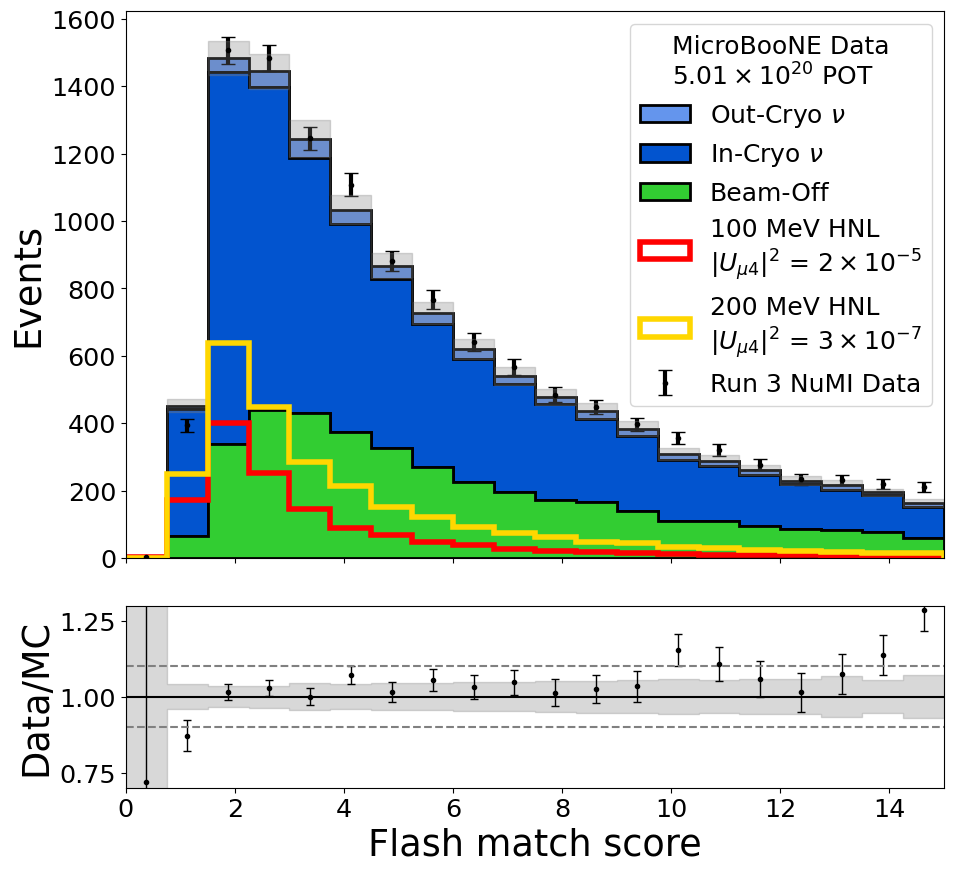

In [78]:
print(f"Plotting {variable} for " + Params["Run"])

if variable in Constants.variable_names_dict: xlabel = Constants.variable_names_dict[variable]
else: xlabel = variable

if variable in Variables_bins.BDT_vars_bins: bins = Variables_bins.BDT_vars_bins[variable]
else: bins = np.linspace(0, 10, 21)
xlims = [bins[0],bins[-1]]
print(bins)
print(xlims)

if Params["Run"]=="run1": 
    Run = "Run 1"
    # titlename = r"MicroBooNE NuMI Data" "\n" r"$2.00\times10^{20}$ POT"
    if variable in ['shr_phi_v', 'trk_phi_v']:titlename = r"MicroBooNE Data $2.00\times10^{20}$ POT"
    else: titlename = r"MicroBooNE Data" "\n" r"$2.00\times10^{20}$ POT"
if Params["Run"]=="run3": 
    Run = "Run 3"
    # titlename = r"MicroBooNE NuMI Data" "\n" r"$5.01\times10^{20}$ POT"
    if variable in ['shr_phi_v', 'trk_phi_v', 'shrclusdir2']:titlename = r"MicroBooNE Data $5.01\times10^{20}$ POT"
    else: titlename = r"MicroBooNE Data" "\n" r"$5.01\times10^{20}$ POT"

# if var in Slice_vars: ylabel = "Events"

save_figures = input("Do you want to save this figure? y/n ")

#ylimits: 1300
sample_colours_test = {'overlay':'#0254cf',
                  'dirtoverlay':'cornflowerblue',
                  'beamoff':'limegreen',
                  'signal':'red',
                  'signal_pi0':'gold'}

# sample_colours_test = {}

# xlabel= "Shower angle [degrees]"

# titlename = r"MicroBooNE NuMI Data" "\n" r"$5.01\times10^{20}$ POT" #Use for plot_text variable

# if dec_type == "ee": text1 = r'$N\rightarrow \nu e^{+}e^{-}$'
# if dec_type == "pi0": text1 = r'$N\rightarrow \nu \pi^{0}$'   

# plt.legend(loc=legloc,frameon=True, fontsize=18, title=plot_text)

if variable == 'shrclusdir2': 
    textpos = [228,450]
    xlabel = r"Shower angle $\theta_{yz}$ [degrees]"
if variable == 'trk_dir_z_v': textpos = [-0.96,950]
if variable == 'shr_energy_tot': textpos = [0.05,780]

textpos = [228,450]

#Set legsize=None to not show legend!
reduced_chi_squared_dict[variable]=PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=xlabel, xlims=xlims, 
                                                                      bins=bins, 
                                   HNL_mass=100, HNL_mass_pi0=200, 
                                   HNLplotscale=5000000, HNL_pi0_plotscale=1000, cutline=[], legloc="best", show_ev_nums=False, 
                                   CalcSys=Calculate_sys, logy=False, colours_sample=sample_colours_test,
                                   xticks=[], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", 
                                   arrow_place=[], ylimit=None, legsize=18, dropdupes=False, err_print=False, Run=Run, chi_squared=True, 
                                   dirt_frac_error=0.75, HNL_scale_label=True, plot_ee=True, plot_pi0=True, 
                                   ncols=1, title_name=None, sub_plot_range=None, sub_ylabel="Data/MC",
                                                                     textpos=textpos, plot_text=titlename, textsize=18)

# plt.text(1.0,0.5, "test")
# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')

Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

additional_name="New_colour"

if save_figures == "y":
    plt.savefig(f"plots/Data_MC_comparison/BDT_input_variables/{Name}{variable}_" + Params["Run"] + f"_{HNL_mass}_{Sys_name}_{additional_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/BDT_input_variables/{Name}{variable}_" + Params["Run"] + f"_{HNL_mass}_{Sys_name}_{additional_name}.pdf")
    print("saved")

In [ ]:
print(len(reduced_chi_squared_dict.keys()))
print(reduced_chi_squared_dict)

In [ ]:
file_loc = "plots/Data_MC_comparison/chi_squared/"

save_chi_squared = input("Do you want to save the chi squared values? y/n ")

if save_chi_squared == "y":

    print(f"Saving chi squared dict as {file_loc}BDT_input_chi_squared_"+Params["Run"]+".pkl")
    with open(f"{file_loc}BDT_input_chi_squared_"+Params["Run"], "wb") as fp:   #Pickling
        pickle.dump(reduced_chi_squared_dict, fp)
        

## Plotting chi squared of all variables

In [ ]:
file_loc = "plots/Data_MC_comparison/chi_squared/"

with open(f"{file_loc}BDT_input_chi_squared_run1", "rb") as fp:   # Unpickling
    chi_test_r1 = pickle.load(fp)
    
with open(f"{file_loc}BDT_input_chi_squared_run3", "rb") as fp:   # Unpickling
    chi_test_r3 = pickle.load(fp)
    


In [ ]:
print(chi_test_r1)
print()
print(chi_test_r3)

In [ ]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=[20,8])

i=0
run_label="Run 1"
plt.bar(chi_test_r1.keys(),chi_test_r1.values(), label=run_label, 
        fill=False,linewidth=3, edgecolor=color_cycle[i])

i=1
run_label="Run 3"
plt.bar(chi_test_r3.keys(),chi_test_r3.values(), label=run_label, 
        fill=False,linewidth=3, edgecolor=color_cycle[i])

correct_names = []
for var in chi_test_r1.keys():
    correct_names.append(Constants.variable_no_units[var])

# plt.xticks(np.array(range(0, len(importance_dict[HNL_mass].keys()))),importance_dict[HNL_mass].keys(),rotation=80)
plt.xticks(np.array(range(0, len(chi_test_r1.keys()))),correct_names,rotation=80)
plt.ylabel(r"Reduced $\chi^2$")
plt.legend(fontsize=24)
plt.tight_layout()

savefig = input("Do you want to save the plot? y/n")

if savefig=="y":
    plt.savefig("plots/Data_MC_comparison/chi_squared/chi_squared_BDT_input_vars.pdf")
    plt.savefig("plots/Data_MC_comparison/chi_squared/chi_squared_BDT_input_vars.png")

## Making legend-only plot

In [ ]:
fig, ax = plt.subplots()
# colors=['sandybrown','seagreen',"darkgreen"]
data_label = f"{Run} NuMI Data"
# labels=[f"Beam-Off",fr"In-Cryo $\nu$",fr"Out-Cryo $\nu$"] 
ax.errorbar([1],[1],yerr=[1],fmt='.',color='black',lw=3,capsize=8, capthick=2,elinewidth=4, ms=15,label=data_label)
# plt.errorbar(bin_center,dat_val,yerr=dat_err,fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label=data_label)
colours_sample = {'overlay':Constants.sample_colours['overlay'],
                  'dirtoverlay':Constants.sample_colours['dirtoverlay'],
                  'beamoff':Constants.sample_colours['beamoff'],
                  'signal':Constants.sample_colours['signal']}

HNL_mass_number = HNL_mass.split("_")[0]

HNL_label = f"{HNL_mass_number} MeV HNL"
labels_sample = {'overlay':fr"In-Cryo $\nu$",
                 'dirtoverlay':fr"Out-Cryo $\nu$",
                 'beamoff':f"Beam-Off",
                 'signal':HNL_label}

labels, colors = [], []
for sample in colours_sample:
    if sample == "signal": continue
    labels.append(labels_sample[sample])
    colors.append(colours_sample[sample])

ax.hist([[1],[1],[1]],histtype="stepfilled",stacked=True,linewidth=5,edgecolor="black", color=colors,label=labels)

plt.hist([1],label=[labels_sample["signal"]],color=colours_sample["signal"],lw=6,histtype="step")
ax.legend()
ax.legend(loc="best")


# get handles and labels for reuse
label_params = ax.get_legend_handles_labels() 
handles, labels=ax.get_legend_handles_labels() 
figl, axl = plt.subplots(figsize=[10,10])
axl.axis("Off")
order = [1, 2, 0, 3, 4]
#order = [3,0,2,1,4]
axl.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center", bbox_to_anchor=(0.5, 0.5), prop={"size":50},frameon=False)

label_params = ax.get_legend_handles_labels() 
handles, labels=ax.get_legend_handles_labels()
order = [1, 2, 0, 3, 4]
axl.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center", bbox_to_anchor=(0.5, 0.5), prop={"size":50},frameon=False)
# plt.text(-0.15,1.1,'MicroBooNE NuMI Data \n'+ r"POT:$5.01\times 10^{20}$ (RHC)",fontsize=50,color='black',alpha=1,verticalalignment='top',horizontalalignment='left',transform=plt.gca().transAxes)

figl.savefig("plots/Data_MC_comparison/Labels_fig.pdf")
figl.savefig("plots/Data_MC_comparison/Labels_fig.png")


## Make all BDT input plots (broken? don't know why)

In [ ]:
np.seterr(divide='ignore', invalid='ignore') # to stop annoying output about dividing by zeros or Nans
vars_to_plot = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                'trk_dir_z_v', 'SliceCaloEnergy2', 'trk_energy_tot', 'shr_energy_tot', 'trk_calo_energy_u_v', 'trk_score_v', 'n_showers']

Calculate_sys = True
Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
loc = f"plots/Data_MC_comparison/BDT_input_variables/"
if Calculate_sys==True: Sys_name = "with_sys"
#Need to add in savefig and savename in argument of plotting function, also make name better.
for var in vars_to_plot:
    print(var)
    savename = f"{Name}{var}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}"
    xlabel = Constants.variable_names_dict[var]
    full_bins = Variables_bins.bins_var[var]
    bins = len(full_bins)-1
    xlims = [full_bins[0],full_bins[-1]]
    print(full_bins)
    PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=xlabel, xlims=xlims, bins=bins, HNL_mass=HNL_mass,
                                       HNLplotscale=2000000,cutline=0.0,legloc="best", show_ev_nums=False, CalcSys=Calculate_sys, xticks = [], 
                                       sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylimit=None, legsize=22, logy=False, display=False,
                                       savefig=False, savename=loc+savename)
    

## Plotting just signal

In [ ]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# End of code